In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import c, epsilon_0
from scipy.signal import find_peaks
inv_c = 1/c
from scipy.interpolate import interp1d
import sys
sys.path.insert(0, "/Users/keenan/Documents/GitHub/plasma-source/khuntstone/eos_bpm/python/")
# Custom modules
from crystal import crystal
import currents as cp
from laser import laser
import phase_retard as pr
import plotting as pl
import thz

import ipywidgets as widgets
from IPython.display import clear_output
outs = widgets.Output()
import time
fpath = "/Users/keenan/Documents/Data/currents/"

In [2]:
def get_peaks(signal, t, dt = 0.25e-12):
    '''
    Function to find the drive and witness peaks of a given signal

    Parameters:
    -----------
    signal : array_like
             Array of some beam parameter (current, E-field) that is dual
             peaked
    dt     : float
             Minimal temporal separation of the bunches (in steps)
    Returns:
    --------
    peaks : array_like
            Array containing the indices of the two peaks
    '''
    max_sig = max(signal)
    # Start cutoff at 5 percent the max signal
    cutoff = 0.05
    # Find distance
    t1   = t[0] + dt
    sep  = np.argmin(abs(t-t1))

    # Start recursion
    peaks  = find_peaks(signal, height = cutoff * max_sig, distance = sep)[0]
    npeaks = len(peaks)
    while len(peaks) > 2:
        cutoff = cutoff + 0.025
        # sometimes the 2nd peak repeats
        peaks = find_peaks(signal, height = cutoff * max_sig, \
                           distance = sep)[0]
        if len(peaks) == 1: 
            cutoff = cutoff - 0.025
            peaks = find_peaks(signal, height = cutoff * max_sig, \
                               distance = sep)[0]
            peaks = [peaks[0], peaks[1]]
            break
        npeaks == len(peaks)
    return peaks

In [3]:
# For EOTD need "gate pulse" i.e. unperturbed probe intensity
# Can normalize maximum intensity to 1, signal will be in AU
fwhm_las = 30e-15 # Laser duration (FWHM), s
rms_las  = fwhm_las / (2*np.sqrt(2*np.log(2)))
dt_las   = rms_las*0.1
N        = 5000
t_las    = np.linspace(-0.5*N*dt_las, 0.5*N*dt_las, N)
I_gate   = np.exp(-t_las*t_las/(2*rms_las*rms_las))
# Interpolating function for I_gate
f_gate = interp1d(t_las, I_gate, bounds_error = False, fill_value = 0)

In [4]:
# Interpolating function for I_gate
f_gate = interp1d(t_las, I_gate, bounds_error = False, fill_value = 0)

In [5]:
tau   = np.linspace(-1000, 1000, 1000)*1e-15
setup = {"ctype"   : "znte",
         "y0"      : 800e-9,
         "tp"      : 30e-15,
         "angle"   : 0,
         "r0"      : 2.5e-3,
         "method"  : "cross",
         "nslice"  : 100,
         "tau"     : tau,
         "t_delay" : 0,
         "tc"      : 480e-15,
         "plot"    : False}

In [6]:
ctype    = setup["ctype"]   # crystal type
y0       = setup["y0"]      # probe central wavelength
tp       = setup["tp"]      # probe FWHM duration
angle    = setup["angle"]   # probe crossing angle
r0       = setup["r0"]      # crystal beamline distance
method   = setup["method"]  # detection method
nslice   = setup["nslice"]  # number of crystal slices
tau      = setup["tau"]     # Probing time array
t_delay  = setup["t_delay"] # Artificial probe delay
tc       = setup["tc"]      # Chirped pulse FWHM
plot     = setup["plot"]    # Plotting preference (True/False)

# Initialize probe
dy = 27e-9;
probe = laser({'y0' : y0, 'dy' : dy, 'tp' : tp})
probe.chirp(tc)
tprobe = t_las
Iprobe = probe.get_inst_amp(tprobe)
# Interpolating function for probe
f_probe = interp1d(tprobe, Iprobe, bounds_error = False, fill_value = 0)
tlim = np.sqrt(tp*tc)

In [7]:
# Easier to get all currents early
cp25 = np.load("currents2p5.npy", allow_pickle=True)
Es   = cp25.item().get("E")
tes  = cp25.item().get("te")
p2ps = np.load("p2p25.npy", allow_pickle=True)

In [8]:
def get_gamma(tau, probe, cry):
    for i in range(len(tau)):
        gamma = 0
        # Get instantaneous frequency/wavelength and create a mini probe
        wi = probe.get_inst_w(tau[i])
        yi = 2*np.pi*c/wi
        mini_probe = laser({"y0" : yi, "dy" : 0, "tp" : tlim})
        n0   = cry.indref(np.array([mini_probe.y0]))[0]
        dz   = d_arr[1]-d_arr[0]
        amp1 = 2 * np.pi * n0**3 * dz/ (mini_probe.y0)
        # Get effective probe velocity
        Lchar, vg_opt = mini_probe.laser_l_char(cry)
        tau_use = tau[i] + t_delay
        for j in range(len(d_arr)):
            fEc = interp1d(tt*1e-12, np.real(Ec[:, j]), bounds_error = False, \
                           fill_value = 0)
            t_probe = d_arr[j] / vg_opt
            t_interp = t_probe + tau_use
            E_eff = fEc(t_interp)
            gamma += E_eff
        # Compute the signal at time tau
        # Get probe intensity with delay
        return amp1*gamma

In [9]:
d     = 300e-6
N_ind = 100
r0    = 2.5e-3
dx    = 1e-6
# Initialize crystal and parameters
cry = crystal(ctype)
# Slice the crystal
j     = np.arange(1, nslice, 1)
dz    = d / nslice
d_arr = (j - 0.5) * dz
# Average over all current profiles
max_sig = np.zeros(N_ind)
sig_diff = np.zeros(N_ind)
start = time.time()
for ind in range(N_ind):
    with outs:
        clear_output()
        print(ind)
    I, ti, p2p = cp.get_current(ind, fpath)
    Ep, tep    = cp.get_E(I, ti, r0+dx)
    Em, tem    = cp.get_E(I, ti, r0-dx)
    # Compute Effective THz pulse
    FErm, fm = thz.raw_field(Em, tem);
    Ecm, ttm = thz.cry_field(tem, FErm, fm, d, probe, cry, nslice = nslice)
    
    FErp, fp = thz.raw_field(Ep, tep);
    Ecp, ttp = thz.cry_field(tep, FErp, fp, d, probe, cry, nslice = nslice)
    # Convert angle to rads
    psi = angle * np.pi / 180
    # preallocate for loop
    sigp   = np.zeros(len(tau))
    sigm   = np.zeros(len(tau))
    for i in range(len(tau)):
        gammap = 0
        gammam = 0
        # Get instantaneous frequency/wavelength and create a mini probe
        wi = probe.get_inst_w(tau[i])
        yi = 2*np.pi*c/wi
        mini_probe = laser({"y0" : yi, "dy" : 0, "tp" : tlim})
        n0   = cry.indref(np.array([mini_probe.y0]))[0]
        dz   = d_arr[1]-d_arr[0]
        amp1 = 2 * np.pi * n0**3 * dz/ (mini_probe.y0)
        # Get effective probe velocity
        Lchar, vg_opt = mini_probe.laser_l_char(cry)
        tau_use = tau[i] + t_delay
        for j in range(len(d_arr)):
            fEcp = interp1d(ttp*1e-12, np.real(Ecp[:, j]), bounds_error = False, \
                           fill_value = 0)
            fEcm = interp1d(ttm*1e-12, np.real(Ecm[:, j]), bounds_error = False, \
                           fill_value = 0)
            t_probe = d_arr[j] / vg_opt
            t_interp = t_probe + tau_use
            E_effp = fEcp(t_interp)
            E_effm = fEcm(t_interp)
            gammap += E_effp
            gammam += E_effm
        # Compute the signal at time tau
        # Get probe intensity with delay
        gammap = amp1*gammap
        gammam = amp1*gammam
        I_gate_int  = f_gate(t_las - 0.5*tau_use)
        I_probe_intp = np.sin(0.5*gammap)*np.sin(0.5*gammap)*f_probe(tprobe - 0.5*tau_use)
        I_probe_intm = np.sin(0.5*gammam)*np.sin(0.5*gammam)*f_probe(tprobe - 0.5*tau_use)
        # Signal is integral
        integrandp = I_gate_int*I_probe_intp
        integrandm = I_gate_int*I_probe_intm
        sigp[i] = np.trapz(integrandp, x = tprobe)
        sigm[i] = np.trapz(integrandm, x = tprobe)
    max_sig[ind] = max(sigp)
    sig_diff[ind] = abs(max(sigp) - max(sigm))
    
print(time.time()-start)

39


KeyboardInterrupt: 

In [ ]:
print(d, ctype)

In [14]:
np.save("300znte.npy", (max_sig, sig_diff))

In [10]:
gap50   = np.load("50gap.npy", allow_pickle=True)
gap300  = np.load("300gap.npy", allow_pickle=True)
znte50  = np.load("50znte.npy", allow_pickle=True)
znte300 = np.load("300znte.npy", allow_pickle=True)

In [11]:
norm = np.amax([gap50[0], gap300[0], znte50[0], znte300[0]])

In [16]:
print(np.nanmean(gap50[0]/norm), np.nanmean(gap50[1]/max(gap50[0])))
print(np.nanmean(gap300[0]/norm), np.nanmean(gap300[1]/max(gap300[0])))
print(np.nanmean(znte50[0]/norm), np.nanmean(znte50[1]/max(znte50[0])))
print(np.nanmean(znte300[0]/norm), np.nanmean(znte300[1]/max(znte300[0])))

0.19104687287866828 0.0010007359175963138
0.6116234370854674 0.0009529777706388688
0.9981860247614718 4.340349000993347e-05
0.9999737305860085 1.0276146584929658e-05


In [13]:
print(np.nanmean(gap50[1]/gap50[0]))
print(np.nanmean(gap300[1]/gap300[0]))
print(np.nanmean(znte50[1]/znte50[0]))
print(np.nanmean(znte300[1]/znte300[0]))

0.0014894259148597242
0.0011403307184313955
4.4307830965349774e-05
1.0276666721929706e-05


In [18]:
1.0276666721929706e-05

1.0276666721929706e-05

In [19]:
1/100000

1e-05

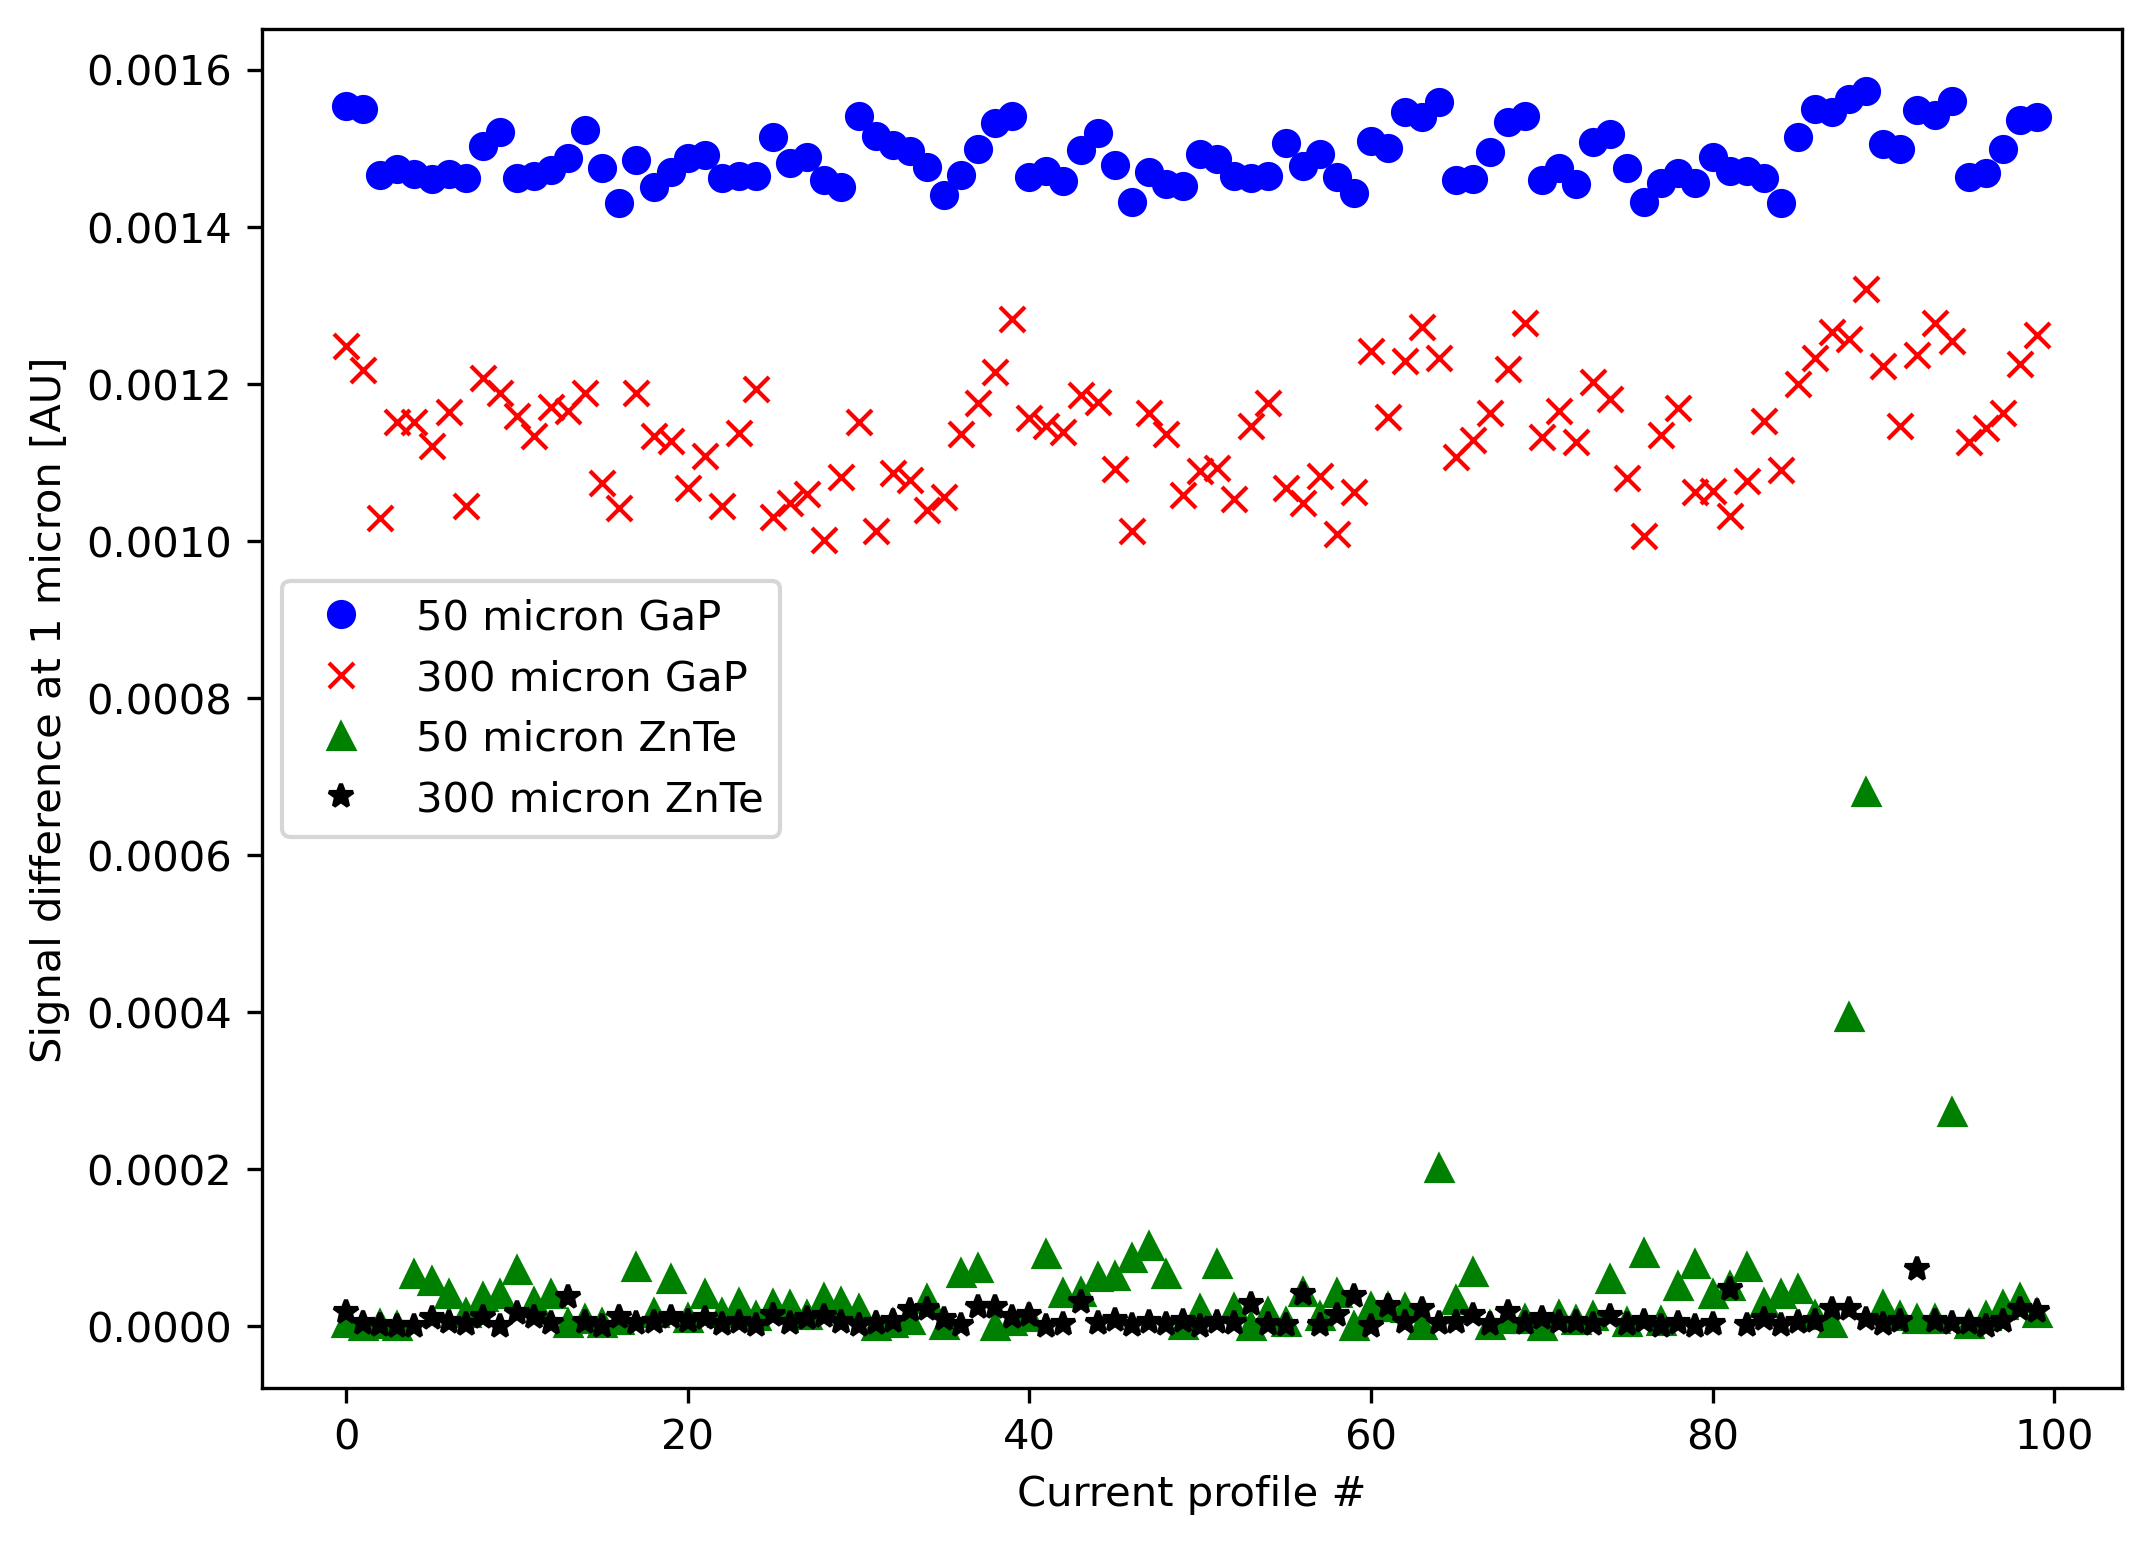

In [15]:
fig = plt.figure(figsize = (8, 6), dpi = 300)
ax  = fig.gca()
ax.set_xlabel("Current profile #")
ax.set_ylabel("Signal difference at 1 micron [AU]")
ax.plot(gap50[1]/gap50[0], 'bo', label = "50 micron GaP")
ax.plot(gap300[1]/gap300[0], 'rx', label = "300 micron GaP")
ax.plot(znte50[1]/znte50[0], 'g^', label = "50 micron ZnTe")
ax.plot(znte300[1]/znte300[0], 'k*', label = "300 micron ZnTe")
ax.legend()
plt.show()

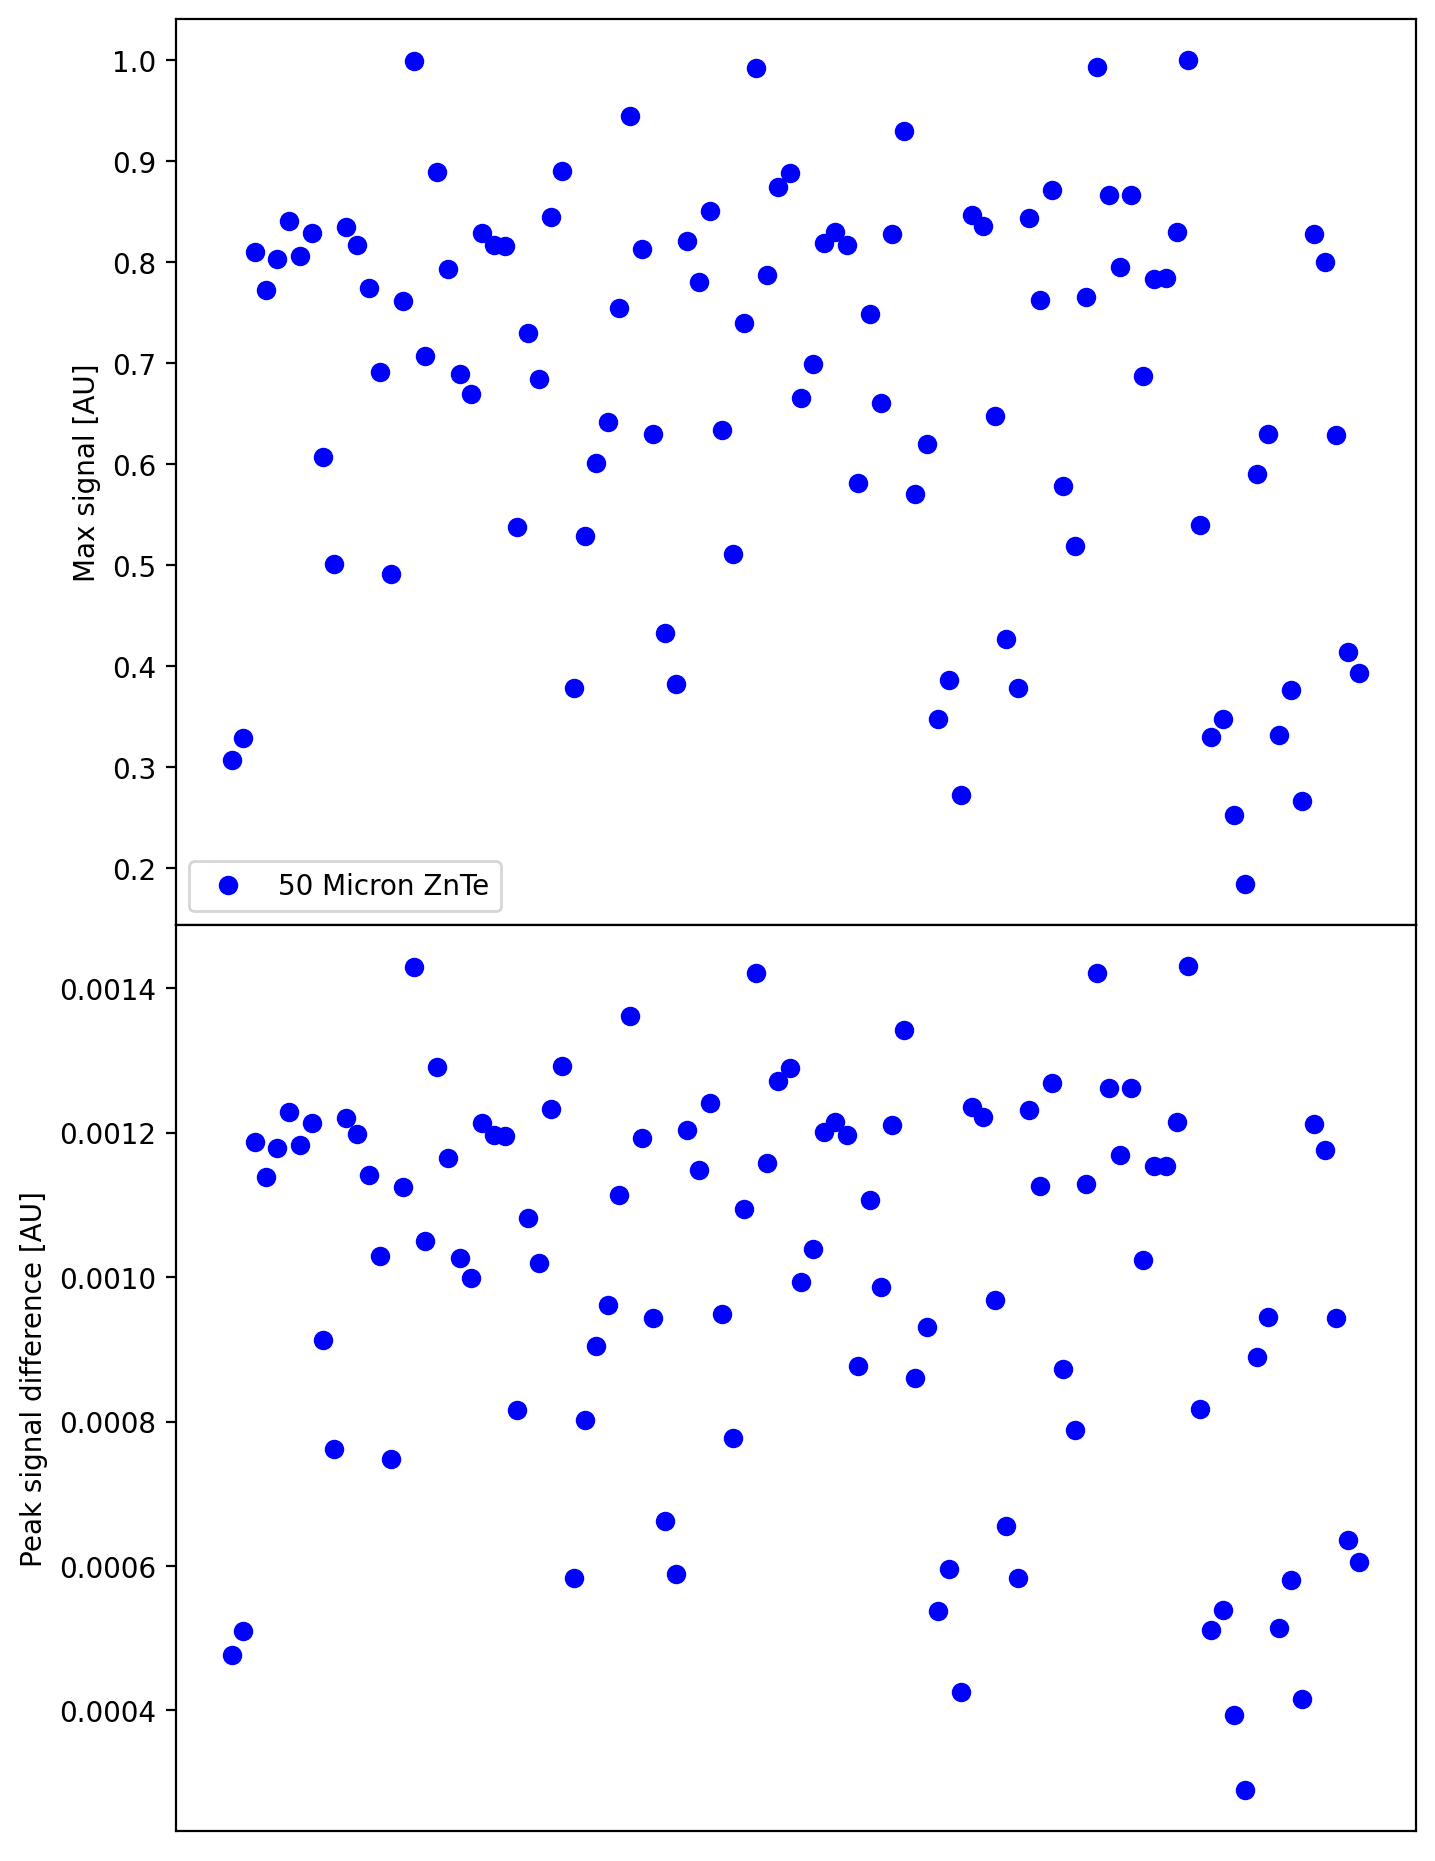

In [12]:
fig = plt.figure(figsize = (8,12), dpi = 200)
ax1 = fig.add_subplot(211)
ax1.set_xticks([])
ax1.set_ylabel("Max signal [AU]")
ax1.set_title("ZnTe")
ax1.plot(znte50[0]/max(znte50[0]), 'rx', label = r'$50 \mu m$')
ax1.plot(znte300[0]/max(znte300[0]), 'b^', label = r'$300 \mu m$')
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.set_xticks([])
ax2.set_ylabel("Peak signal difference [AU]")
ax2.plot(znte50[1]/max(znte50[0]), 'rx')
ax2.plot(znte300[1]/max(znte300[0]), 'b^')
plt.subplots_adjust(hspace = 0)
plt.show()

In [18]:
np.save("znte_ratios.npy", (max_sig, sig_diff))

array([  6.00600601, 102.1021021 ,          nan,  32.03203203,
        64.06406406,   6.00600601])

In [20]:
d = 250e-6
ind = 0
# Initialize crystal and parameters
cry = crystal(ctype)
# Slice the crystal
j     = np.arange(1, nslice, 1)
dz    = d / nslice
d_arr = (j - 0.5) * dz
# Average over all current profiles
E  = Es[ind, :]
te = tes[ind, :]
p2p = p2ps[ind]
# Compute Effective THz pulse
FEr, f = thz.raw_field(E, te);
Ec, tt = thz.cry_field(te, FEr, f, d, probe, cry, nslice = nslice)
# Convert angle to rads
psi = angle * np.pi / 180
# preallocate for loop
sig   = np.zeros(len(tau))
upd   = int(len(tau)/10)
for i in range(len(tau)):
    gamma = 0
    # Get instantaneous frequency/wavelength and create a mini probe
    wi = probe.get_inst_w(tau[i])
    yi = 2*np.pi*c/wi
    mini_probe = laser({"y0" : yi, "dy" : 0, "tp" : tlim})
    n0   = cry.indref(np.array([mini_probe.y0]))[0]
    dz   = d_arr[1]-d_arr[0]
    amp1 = 2 * np.pi * n0**3 * dz/ (mini_probe.y0)
    # Get effective probe velocity
    Lchar, vg_opt = mini_probe.laser_l_char(cry)
    tau_use = tau[i] + t_delay
    for j in range(len(d_arr)):
        fEc = interp1d(tt*1e-12, np.real(Ec[:, j]), bounds_error = False, \
                       fill_value = 0)
        t_probe = d_arr[j] / vg_opt
        t_interp = t_probe + tau_use
        E_eff = fEc(t_interp)
        gamma += E_eff
    # Compute the signal at time tau
    # Get probe intensity with delay
    gamma = amp1*gamma
    I_gate_int  = f_gate(t_las - 0.5*tau_use)
    I_probe_int = np.sin(0.5*gamma)*np.sin(0.5*gamma)*f_probe(tprobe - 0.5*tau_use)
    # Signal is integral
    integrand = I_gate_int*I_probe_int
    sig[i] = np.trapz(integrand, x = tprobe)
sig = np.flip(sig)
tau = tau - tau[np.argmax(sig)]
pks = get_peaks(sig, tau)